<a href="https://colab.research.google.com/github/ArtyomShabunin/SMOPA/blob/main/lesson_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://prana-system.com/files/110/rds_color_full.png" alt="tot image" width="300"  align="center"/> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<img src="https://mpei.ru/AboutUniverse/OficialInfo/Attributes/PublishingImages/logo1.jpg" alt="mpei image" width="200" align="center"/>
<img src="https://mpei.ru/Structure/Universe/tanpe/structure/tfhe/PublishingImages/tot.png" alt="tot image" width="100"  align="center"/>

---

# **Системы машинного обучения и предиктивной аналитики в тепловой и возобновляемой энергетике**  

# ***Практические занятия***


---

# Занятие №9
# Прогнозирование временных рядов методами глубокого обучения
**9 апреля 2025г.**

---

Задачу прогнозирования временных рядов можно эффективно решать методами глубокого обучения, особенно когда данные содержат нелинейные зависимости, сезонность или сложную динамику. Вот основные подходы и архитектуры, которые используются:

---

### 1. **Рекуррентные нейронные сети (RNN)**
Используются для последовательной обработки данных.

- **Vanilla RNN** — базовая форма RNN, редко используется из-за проблем исчезающего градиента.
- **LSTM (Long Short-Term Memory)** — популярный выбор, хорошо справляется с долговременными зависимостями.
- **GRU (Gated Recurrent Unit)** — упрощённая версия LSTM, быстрее обучается и требует меньше вычислений.

**Пример использования:**  
Вход: последовательность значений временного ряда  
Выход: значение (или несколько) на следующем шаге  

---

### 2. **1D-Сверточные сети (CNN для временных рядов)**
Могут извлекать локальные шаблоны в данных.

- Эффективны для коротких зависимостей и быстрых расчётов.
- Часто используются в комбинации с RNN/LSTM (например, CNN+LSTM).

---

### 3. **Encoder-Decoder архитектуры**
Подход из области машинного перевода, адаптированный к временным рядам:

- **Encoder** считывает входную последовательность.
- **Decoder** генерирует выходную последовательность (будущие значения).

---

### 4. **Transformer и его модификации**
Модель, изначально разработанная для NLP, показала себя отлично и в задаче прогнозирования временных рядов.

- **Informer, Autoformer, Transformer-XL, TimesNet** — специализированные архитектуры для временных рядов.
- Transformer позволяет учитывать долгосрочные зависимости благодаря механизмам внимания.

---

### 5. **Сети прямого распространения (MLP)**
Простые полносвязные сети можно применять, если на вход подаются фичи из скользящего окна (например, 10 предыдущих точек). Хорошо работают при небольшой сложности данных.

---

### 6. **Гибридные подходы**
Комбинации из разных типов сетей:
- **CNN+LSTM**
- **Encoder (CNN/LSTM) + Attention + Decoder**
- **Transformer + Residual MLP**

---

### Как строится вход для модели:
- **Скользящее окно**: берём последние `n` точек временного ряда как вход, предсказываем следующие `m` точек.
- Можно добавлять фичи:
  - Временные метки (час, день недели, месяц)
  - Внешние воздействия (управляющие сигналы, температура воздуха и т.д.)


In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", rc={'figure.figsize':(15,6)})

import numpy as np
import pandas as pd
from sklearn import preprocessing
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import lr_scheduler

from tqdm import tqdm

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
device

device(type='cuda')

## Загрузка данных
Набор содержит данные о почасовом производстве ветряной и солнечной электроэнергии (в МВт) во французской электросети с 2020 года.

In [ ]:
import gdown
import warnings
warnings.filterwarnings('ignore')
gdown.download('https://drive.google.com/uc?id=1NAYPaEkovk7jvaURdjI0nCi7CUMxry7W', verify=False)

df = pd.read_csv('./intermittent-renewables-production-france.csv')

Downloading...
From: https://drive.google.com/uc?id=1NAYPaEkovk7jvaURdjI0nCi7CUMxry7W
To: /content/intermittent-renewables-production-france.csv
100%|██████████| 5.12M/5.12M [00:00<00:00, 27.4MB/s]


In [ ]:
df = pd.read_csv('intermittent-renewables-production-france.csv')
df = df.rename(columns={'Date and Hour' : 'DateTime'})
df['DateTime'] = df['DateTime'].str.slice(stop=-6)
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values(ascending=True,by='DateTime')
df = df.drop(['Date','dayOfYear','dayName','monthName'],axis=1)
df = df.dropna()
df = df.set_index("DateTime")

In [ ]:
solar = df[df['Source'] == 'Solar']['Production']
wind = df[df['Source'] == 'Wind']['Production']

In [ ]:
solar.sample(5)

,Production
DateTime,
2021-02-12 14:00:00,746.0
2021-03-23 09:00:00,2709.0
2023-01-04 16:00:00,469.0
2023-06-16 02:00:00,0.0
2022-10-21 23:00:00,1.0


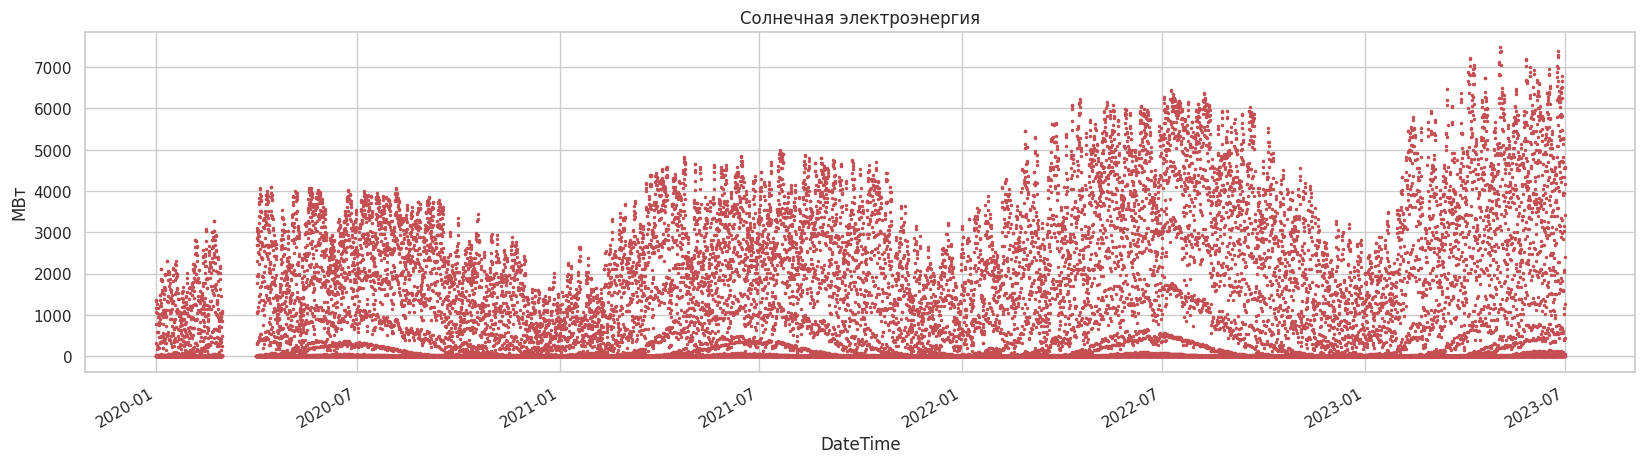

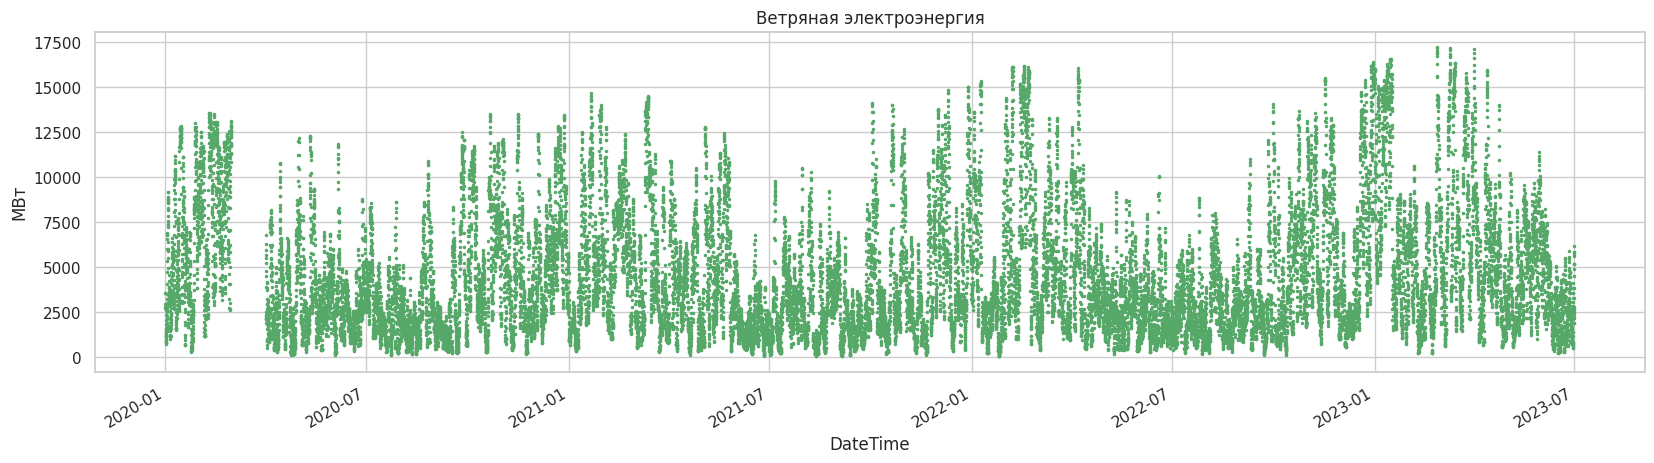

In [ ]:
color_pal = sns.color_palette()
solar.plot(style='.',
          figsize=(20, 5),
          ms=3,
          color=color_pal[3],
          title='Солнечная электроэнергия')
plt.ylabel("МВт")
plt.show()

wind.plot(style='.',
          figsize=(20, 5),
          ms=3,
          color=color_pal[2],
          title='Ветряная электроэнергия')
plt.ylabel("МВт")
plt.show()

## Сформируем датасет на основе данных о производстве солнечной электроэнергии
### Разделим данные на обучающую и тестовую выборки

In [ ]:
cutoff_date = '2023-01-01'

solar_train = solar[solar.index < cutoff_date].copy()
solar_test = solar[solar.index >= cutoff_date].copy()

print(f"Train: {solar_train.shape[0]} записей")
print(f"Test: {solar_test.shape[0]} записей")

Train: 25558 записей
Test: 4343 записей


### Нормализация или стандартизация данных

In [ ]:
solar_scaler = preprocessing.MinMaxScaler() # нормализация данных
# solar_scaler = preprocessing.StandardScaler() # стандартизация данных

solar_train_scaled = pd.DataFrame(
    solar_scaler.fit_transform(solar_train.values[:, None]),
    index=solar_train.index)

solar_test_scaled = pd.DataFrame(
    solar_scaler.transform(solar_test.values[:, None]),
    index=solar_test.index)

solar_train_scaled.describe()

,0
count,25558.000000
mean,0.155712
std,0.225198
min,0.000000
25%,0.000155
50%,0.005895
75%,0.280329
max,1.000000


### Dataset и DataLoader

<img src="https://github.com/ArtyomShabunin/SMOPA-25/blob/main/imgs/l9_fig1.png?raw=true" alt="trend_seasonality" width="800"  align="center"/>

In [ ]:
class SolarDataset(Dataset):
    def __init__(self, data, n_lags, horizon):
        self.n_lags = n_lags
        self.horizon = horizon
        data = data.reshape(-1)
        self.x = torch.tensor(data[:-self.horizon], dtype=torch.float32)
        self.y = torch.tensor(data[self.n_lags:],dtype=torch.float32)

    def __getitem__(self, idx):
        return self.x[idx:idx+self.n_lags], self.y[idx:idx+self.horizon]

    def __len__(self):
        return self.y.shape[0]-self.horizon+1

In [ ]:
N_LAGS = 10
HORIZON = 100
HIDDEN_DIM = 1024
HIDDEN_NUM = 2

solar_dataset = SolarDataset(solar_train_scaled.values, N_LAGS, HORIZON)
print(f"Размер датасета: {len(solar_dataset)}")

Размер датасета: 25449


In [ ]:
solar_train_size = int(0.8 * len(solar_dataset))
solar_valid_size = len(solar_dataset) - solar_train_size

solar_train_dataset = Subset(solar_dataset, range(solar_train_size))
solar_valid_dataset = Subset(
    solar_dataset, range(solar_train_size, solar_train_size + solar_valid_size))

batch_size = 1024

solar_train_loader = DataLoader(solar_train_dataset, batch_size=batch_size, shuffle=True)
solar_valid_loader = DataLoader(solar_valid_dataset, batch_size=batch_size, shuffle=True)

## Предсказание производства солнечной электроэнергии


Инициализируем переменные для дальнейшего сравнения моделей

In [16]:
MAE_prediction = {}
RMSE_prediction = {}

#### Функция для обучения моделей

In [17]:
def train_model(model, loss_function, optimizer, scheduler, num_epochs=100):

  loaders = {"train": solar_train_loader, "valid": solar_valid_loader}
  losses = {"train": [], "valid": []}
  lr = []

  for epoch in tqdm(range(epochs)):

    for k, dataloader in loaders.items():
      running_loss = []

      for x_batch, y_batch in dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        if k == "train":
          model.train()
          optimizer.zero_grad()
          out = model(x_batch, y_batch.shape[1])

        else:
          model.eval()
          with torch.no_grad():
            out = model(x_batch, y_batch.shape[1])

        loss = loss_function(out, y_batch)
        running_loss.append(loss.item())

        if k == "train":
          loss.backward()
          optimizer.step()

      losses[k].append(np.array(running_loss).mean())
    lr.append(scheduler.get_last_lr())
    scheduler.step(losses["train"][-1])

  return model, losses, lr

### Полносвязная нейронная сеть (многослойный персептрон)

Использование **полносвязной нейронной сети (fully connected neural network, FCNN или просто MLP — Multi-Layer Perceptron)** для задачи прогнозирования временного ряда имеет свои **преимущества и недостатки**, особенно по сравнению со специализированными архитектурами, такими как RNN, LSTM, GRU, CNN и Transformer.

---

**Преимущества полносвязной нейросети:**

1. **Простота реализации**  
   Полносвязная сеть — одна из самых простых архитектур. Не требует сложной подготовки данных, как, например, рекуррентные сети.

2. **Быстрое обучение**  
   За счёт отсутствия последовательных зависимостей обучение может быть быстрее, особенно на GPU.

3. **Гибкость**  
   Может моделировать нелинейные зависимости между входом и выходом при правильном выборе архитектуры и обучающих данных.

4. **Параллельность**  
   Обработка каждого входного примера может быть полностью параллелизирована, что ускоряет тренировку и предсказания.

---

**Недостатки:**

1. **Игнорирование временной структуры**  
   FCNN не обладает "памятью" и не учитывает порядок входных значений. Временные зависимости надо явно закодировать — например, подавать фиксированное окно прошлых значений.

2. **Плохо обобщается на длинные зависимости**  
   Если значимые события происходят далеко во времени, FCNN может не уловить эти долгосрочные связи.

3. **Фиксированный входной размер**  
   Нужно задавать длину временного окна (например, последние 10 шагов). Это ограничивает гибкость модели.

4. **Сложность в учёте сезонности и трендов**  
   В отличие от архитектур, специально предназначенных для анализа временных зависимостей (например, LSTM), FCNN хуже захватывает сезонные и трендовые паттерны, если они не явно выражены.




In [18]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, hidden_num=1):
        super(FeedForwardNN, self).__init__()
        self.hidden_num = hidden_num
        self.linear = nn.ModuleList()
        for i in range(self.hidden_num):
            if i == 0:
              self.linear.append(nn.Linear(input_dim, hidden_dim))
            else:
              self.linear.append(nn.Linear(hidden_dim, hidden_dim))
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, horizon):
        for i in range(self.hidden_num):
            x = F.relu(self.linear[i](x))
        result = self.out(x)
        return result

Инмциализация модели

In [20]:
FC_model = FeedForwardNN(input_dim=N_LAGS,
                      hidden_dim=HIDDEN_DIM,
                      output_dim=HORIZON,
                      hidden_num=HIDDEN_NUM).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(FC_model.parameters(), lr=0.01)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3,
                                           patience=3, threshold=0.0001)

epochs = 20

Обучение модели

In [21]:
FC_model, losses, lr = train_model(FC_model, loss_fn, optimizer, scheduler, num_epochs=epochs)

100%|██████████| 20/20 [00:05<00:00,  3.38it/s]


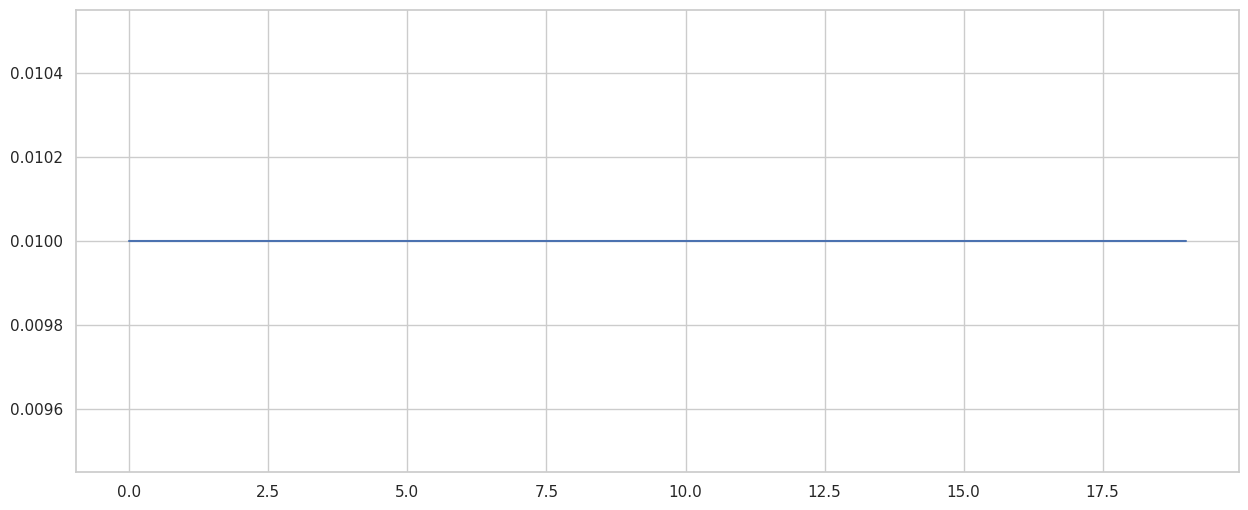

In [23]:
plt.plot(lr);

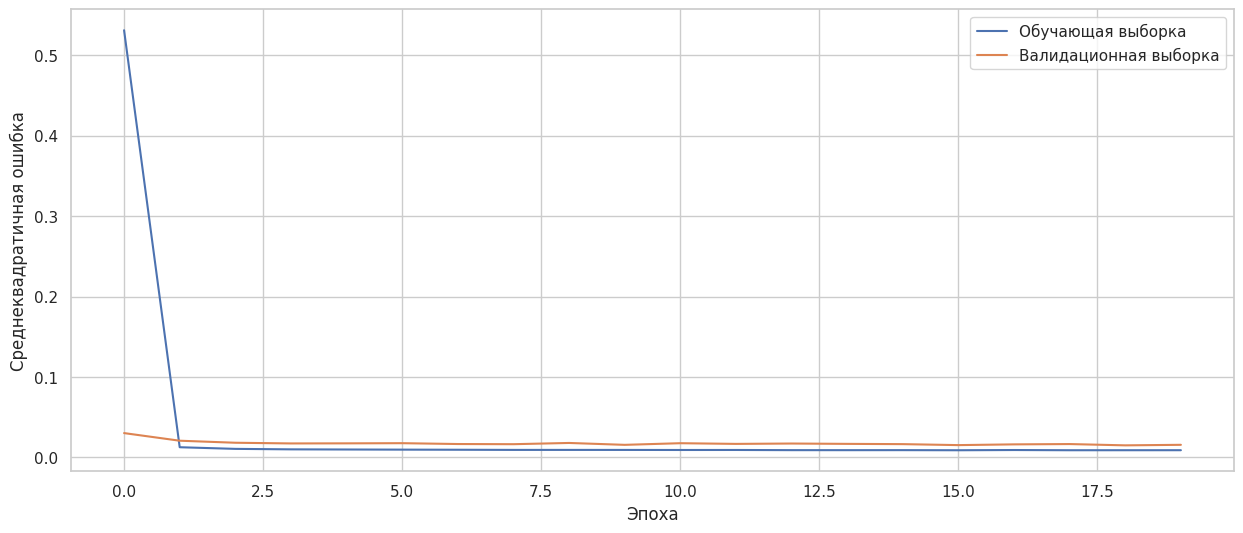

In [24]:
plt.plot(losses["train"], label="Обучающая выборка");
plt.plot(losses["valid"], label="Валидационная выборка");
plt.legend();
plt.xlabel("Эпоха");
plt.ylabel("Среднеквадратичная ошибка");

In [25]:
print(f"Минимальный loss на тренировочной выборке: {min(losses['train']):.4f}")
print(f"Минимальный loss на валидационной выборке: {min(losses['valid']):.4f}")

Минимальный loss на тренировочной выборке: 0.0089
Минимальный loss на валидационной выборке: 0.0150


#### Анализ качества модели

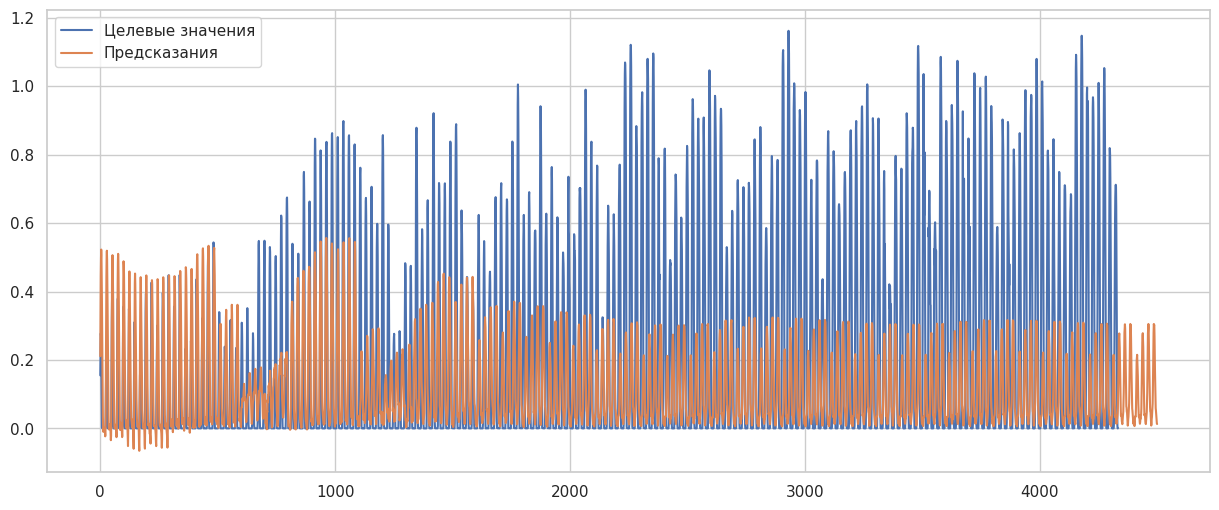

In [29]:
FC_model.to('cpu')

start = 0
predicted_steps = 45
in_data = solar_test_scaled.values[start:start+N_LAGS].reshape(-1)
for i in range(predicted_steps):
    out_data = FC_model(torch.tensor(in_data[-N_LAGS:], dtype=torch.float32), HORIZON)
    in_data = np.concatenate((in_data, out_data.detach().numpy()))

fc_pred = in_data[start+N_LAGS:]
plt.plot(
    solar_test_scaled.values[start+N_LAGS:start+predicted_steps*HORIZON],
    label="Целевые значения")
plt.plot(fc_pred, label="Предсказания");
plt.legend();

Базовая модель

In [30]:
solar_baseline_pred = np.array(
    [solar_test_scaled.mean() for _ in range(len(solar_test_scaled))])

**MAE (Mean Absolute Error)**

Средняя абсолютная ошибка:

In [67]:
from sklearn.metrics import mean_absolute_error

len_of_seq = np.min(
    [fc_pred.shape[0], solar_test_scaled.values[N_LAGS:].shape[0]])

FC_mae = mean_absolute_error(
    solar_test_scaled.values[N_LAGS:][:len_of_seq],
    fc_pred[:len_of_seq]
)

baseline_mae = mean_absolute_error(
    solar_test_scaled.values[N_LAGS:][:len_of_seq],
    solar_baseline_pred[:len_of_seq]
)

print(f"FCNN MAE: {FC_mae:.4f}")
print(f"Baseline MAE: {baseline_mae:.4f}")

MAE_prediction["FCNN"] = FC_mae
MAE_prediction["Baseline"] = baseline_mae

MAE: 0.2621
Baseline MAE: 0.2602


**RMSE (Root Mean Squared Error)**

Корень из средней квадратичной ошибки:

In [33]:
from sklearn.metrics import mean_squared_error

FC_rmse = mean_squared_error(
    solar_test_scaled.values[N_LAGS:][:len_of_seq],
    fc_pred[:len_of_seq]
)

baseline_rmse = mean_squared_error(
    solar_test_scaled.values[N_LAGS:][:len_of_seq],
    solar_baseline_pred[:len_of_seq]
)

print(f"FCNN RMSE: {FC_rmse:.4f}")
print(f"Baseline RMSE: {baseline_rmse:.4f}")

RMSE_prediction["FCNN"] = FC_rmse
RMSE_prediction["Baseline"] = baseline_rmse

RMSE: 0.1120
Baseline RMSE: 0.0942


### Рекуррентная нейронная сеть (RNN)

---

**Преимущества RNN:**

1. **Учет временных зависимостей**  
   RNN умеют **запоминать информацию о предыдущих состояниях**, что позволяет учитывать порядок значений — ключевая особенность временных рядов.

2. **Гибкость по длине входа/выхода**  
   Можно подавать последовательности **разной длины**, и сеть может генерировать выходные последовательности также разной длины — удобно для задач с переменной длиной данных.

3. **Плавное моделирование трендов и сезонности**  
   Благодаря "памяти" может захватывать как **локальные**, так и **долгосрочные зависимости** (особенно в сочетании с LSTM/GRU).

4. **Хорошо подходят для многомерных временных рядов**  
   Можно одновременно подавать несколько сигналов/каналов (например, температуру, давление и т.п.) и прогнозировать на их основе.

---

**Недостатки RNN:**

1. **Проблемы с долгосрочной памятью**  
   Обычные RNN страдают от **затухающего или взрывающегося градиента**, что мешает эффективно захватывать зависимости на больших интервалах времени. (Для этого придумали LSTM и GRU.)

2. **Медленная и последовательная обработка**  
   Обработка последовательностей **непараллельна** — каждое состояние зависит от предыдущего. Это усложняет обучение и замедляет предсказания.

3. **Сложнее обучать и отлаживать**  
   RNN чувствительны к выбору гиперпараметров, начальным весам и другим деталям. Могут "залипать" в локальных минимумах.

4. **Большая потребность в данных**  
   Для качественного обучения RNN **нужно больше данных**, особенно если прогнозируется длинный горизонт.

5. **Проблемы со стационарностью и масштабированием**  
   При нестабильных данных без нормализации RNN может "плыть". Также она может хуже работать, если данные сильно изменяются со временем (например, резкие скачки и выбросы).

**LSTM (Long Short-Term Memory)** — это **тип рекуррентной нейронной сети (RNN)**, разработанный для лучшего захвата **долгосрочных зависимостей** во временных рядах.  
В отличие от обычной RNN, LSTM **умело управляет памятью** — решает проблему **затухающего градиента**, благодаря чему может "помнить" важные события, случившиеся десятки или сотни шагов назад.

Внутри LSTM есть три "входа":
- **Forget gate** — решает, что выбросить из памяти.
- **Input gate** — решает, что сохранить.
- **Output gate** — решает, что отдать наружу в текущем шаге.

Это делает LSTM особенно хорошим для сложных последовательностей: язык, время, сигналы и т.д.

---

**Autoregressive LSTM** — это **способ применения LSTM**, при котором модель **пошагово предсказывает будущее, используя собственные предыдущие предсказания как вход**.

Как это работает:
1. Модель получает входные данные (например, 10 прошлых значений).
2. Предсказывает следующий шаг (например, $ y_{t+1} $).
3. Этот предсказанный $ y_{t+1} $ подаётся обратно на вход, чтобы предсказать $ y_{t+2} $.
4. И так далее — autoregressive = "автоподкорм".

---

Преимущества autoregressive LSTM:
- Позволяет строить **прогноз на произвольное количество шагов вперёд**, даже если модель обучалась предсказывать только 1 шаг.
- Модель может **накапливать эффект ошибок или трендов** — иногда это даже полезно.

Недостатки:
- Ошибки **накапливаются** с каждым шагом: если модель ошиблась на $ t+1 $, следующая ошибка будет ещё больше.
- Модель **не учится предсказывать сразу всю последовательность** — только по одному шагу, что может быть неэффективно для некоторых задач.


**autoregressive LSTM**

- сначала модель "считывает" входной временной ряд длиной `n_lags`;
- затем **по одному** предсказывает `horizon` шагов вперёд;
- на каждом следующем шаге использует **предыдущее предсказание как вход**.

In [37]:
class LSTMForecastAuto(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, input_seq, horizon):
        outputs = []

        input_seq = input_seq[:,:,None]

        lstm_out, (hn, cn) = self.lstm(input_seq)

        # Первый шаг – прямое предсказание
        pred = self.linear(lstm_out[:, -1, :])  # [batch, 1]
        outputs.append(pred)
        input = pred.unsqueeze(1)

        for _ in range(horizon - 1):
            out, (hn, cn) = self.lstm(input, (hn, cn))
            pred = self.linear(out[:, -1, :])
            outputs.append(pred)
            input = pred.unsqueeze(1)

        return torch.cat(outputs, dim=1)

Создадим новые ```solar_train_loader``` и ```solar_train_loader```

In [38]:
N_LAGS = 20
HORIZON = 20

solar_dataset = SolarDataset(solar_train_scaled.values, N_LAGS, HORIZON)

solar_train_size = int(0.8 * len(solar_dataset))
solar_valid_size = len(solar_dataset) - solar_train_size

solar_train_dataset = Subset(solar_dataset, range(solar_train_size))
solar_valid_dataset = Subset(
    solar_dataset, range(solar_train_size, solar_train_size + solar_valid_size))

batch_size = 1024

solar_train_loader = DataLoader(solar_train_dataset, batch_size=batch_size, shuffle=True)
solar_valid_loader = DataLoader(solar_valid_dataset, batch_size=batch_size, shuffle=True)

Инициализация и обучение модели

In [44]:
HIDDEN_SIZE = 64
LSTM_LAYERS = 1

LSTM_model = LSTMForecastAuto(hidden_size=HIDDEN_SIZE, num_layers=LSTM_LAYERS).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=0.01)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3,
                                           patience=3, threshold=0.0001)

epochs = 20

In [45]:
LSTM_model, losses, lr = train_model(LSTM_model, loss_fn, optimizer, scheduler, num_epochs=epochs)

100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


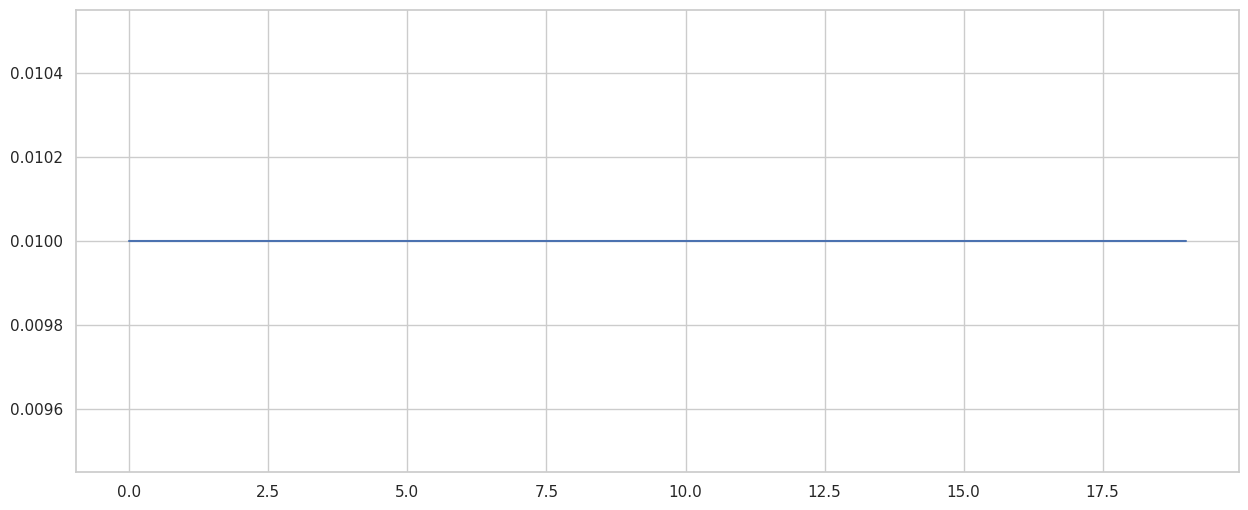

In [46]:
plt.plot(lr);

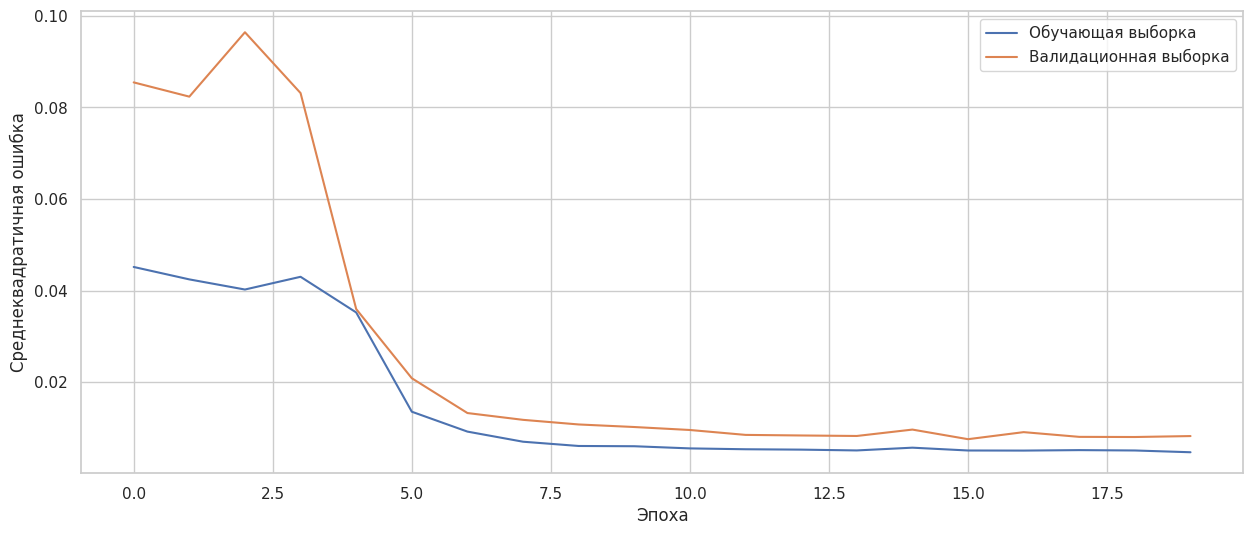

In [47]:
plt.plot(losses["train"], label="Обучающая выборка");
plt.plot(losses["valid"], label="Валидационная выборка");
plt.legend();
plt.xlabel("Эпоха");
plt.ylabel("Среднеквадратичная ошибка");

In [89]:
print(f"Минимальный loss на тренировочной выборке: {min(losses['train']):.4f}")
print(f"Минимальный loss на валидационной выборке: {min(losses['valid']):.4f}")

Минимальный loss на тренировочной выборке: 0.0013
Минимальный loss на валидационной выборке: 0.0026


#### Анализ качества модели

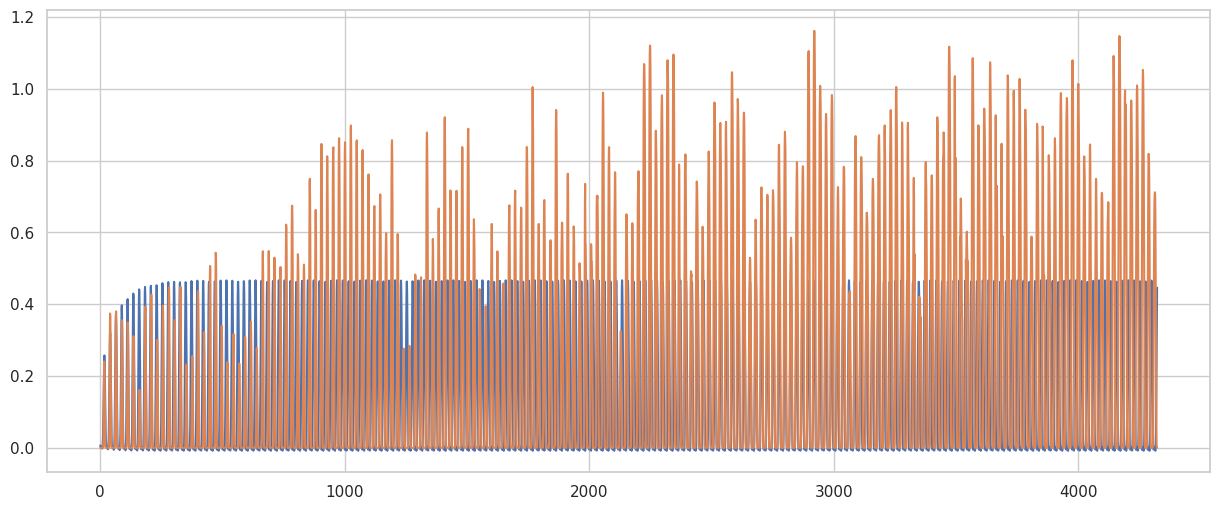

In [72]:
LSTM_model.to('cpu')

# horizon_for_test = 100
horizon_for_test = solar_test_scaled.shape[0] - N_LAGS

lstm_pred = LSTM_model(
    torch.tensor(
        solar_test_scaled.values[:N_LAGS].reshape(-1)[None,:],
        dtype=torch.float32),
    horizon_for_test
    )[0]

plt.plot(lstm_pred.detach().numpy());
plt.plot(solar_test_scaled.values[N_LAGS:N_LAGS+horizon_for_test].reshape(-1));

**MAE (Mean Absolute Error)**

Средняя абсолютная ошибка:

In [73]:
len_of_seq = np.min(
    [lstm_pred.shape[0], solar_test_scaled.values[N_LAGS:,:].shape[0]])

lstm_mae = mean_absolute_error(
    solar_test_scaled.values[N_LAGS:][:len_of_seq],
    lstm_pred[:len_of_seq].detach().numpy()
)

baseline_mae = mean_absolute_error(
    solar_test_scaled.values[N_LAGS:][:len_of_seq],
    solar_baseline_pred[N_LAGS:][:len_of_seq]
)

print(f"LSTM MAE: {lstm_mae:.4f}")
print(f"Baseline MAE: {baseline_mae:.4f}")

MAE_prediction["LSTM"] = lstm_mae

LSTM MAE: 0.2634
Baseline MAE: 0.2602


**RMSE (Root Mean Squared Error)**

Корень из средней квадратичной ошибки:

In [74]:
LSTM_rmse = mean_squared_error(
    solar_test_scaled.values[N_LAGS:][:len_of_seq],
    lstm_pred[:len_of_seq].detach().numpy()
)

baseline_rmse = mean_squared_error(
    solar_test_scaled.values[N_LAGS:][:len_of_seq],
    solar_baseline_pred[:len_of_seq]
)

print(f"LSTM RMSE: {LSTM_rmse:.4f}")
print(f"Baseline RMSE: {baseline_rmse:.4f}")

RMSE_prediction["LSTM"] = LSTM_rmse

LSTM RMSE: 0.1361
Baseline RMSE: 0.0944


### LSTM с дополнительными признаками для учета сезонности

Синусоидальные преобразования временных признаков — это **популярный способ добавить в модель информацию о сезонности или периодичности**, особенно в задачах временных рядов. Давай коротко, но по делу: что это, зачем, как использовать, и примеры.

---

Временными метки (например, час, день недели, месяц) - **циклические**. Например:
- 23:00 → 0:00 → 1:00 — это не просто увеличение, а переход по кругу;
- Понедельник → воскресенье → понедельник.

Чтобы модель понимала, что **0 и 23 часа "близки"**, применяют синусоиду и косинус:

```python
sin_val = sin(2π * t / T)
cos_val = cos(2π * t / T)
```

где:
- `t` — значение (например, час от 0 до 23);
- `T` — длина цикла (например, 24 для часов в сутках).

---

Без синуса/косинуса:
- `0` и `23` далеки (23 - 0 = 23), хотя на самом деле они "рядом" по времени.
- Модель не видит периодичности, теряется фаза цикла.

С синусом/косинусом:
- значения образуют **единичную окружность** → правильно отображают цикличность;
- модель получает контекст: "где во времени находится точка".

---

Синусоидальные преобразования — **простой и мощный способ** научить модель чувствовать **время и циклы**.

Добавим новые признаки в наши данные

In [75]:
df = pd.read_csv('intermittent-renewables-production-france.csv')
df = df.rename(columns={'Date and Hour' : 'DateTime'})
df['DateTime'] = df['DateTime'].str.slice(stop=-6)
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['sin_dayOfYear'] = np.sin(2*np.pi*df['dayOfYear']/365)
df['cos_dayOfYear'] = np.cos(2*np.pi*df['dayOfYear']/365)

df = df.sort_values(ascending=True,by='DateTime')
df = df.drop(['Date','dayName','monthName', 'dayOfYear'],axis=1)
df = df.dropna()
df = df.set_index("DateTime")

In [76]:
solar = df[df['Source'] == 'Solar'][['Production', 'sin_dayOfYear', 'cos_dayOfYear']]
solar.head()

,Production,sin_dayOfYear,cos_dayOfYear
DateTime,,,
2020-01-01 00:00:00,0.0,0.017213,0.999852
2020-01-01 01:00:00,0.0,0.017213,0.999852
2020-01-01 02:00:00,0.0,0.017213,0.999852
2020-01-01 03:00:00,0.0,0.017213,0.999852
2020-01-01 04:00:00,0.0,0.017213,0.999852


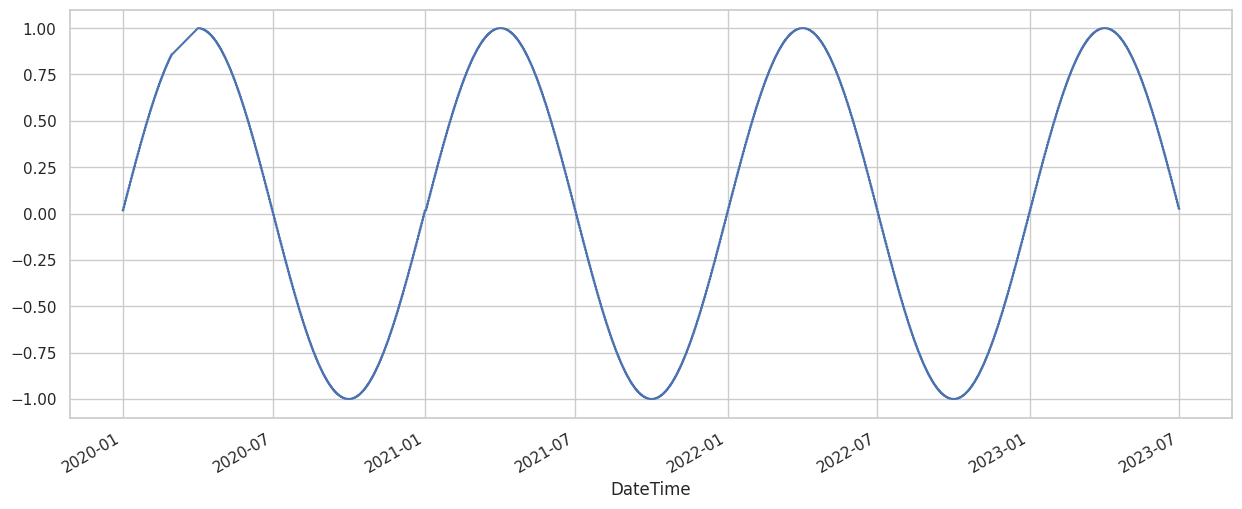

In [77]:
solar['sin_dayOfYear'].plot();

Делим данные на тренировочную и тестовую выборки

In [78]:
cutoff_date = '2023-01-01'

solar_train = solar[solar.index < cutoff_date].copy()
solar_test = solar[solar.index >= cutoff_date].copy()

print(f"Test: {solar_test.shape[0]} записей")

Test: 4343 записей


Масштабируем данные

In [79]:
solar_scaler = preprocessing.MinMaxScaler() # нормализация данных
# solar_scaler = preprocessing.StandardScaler() # стандартизация данных

solar_train_scaled = pd.DataFrame(
    solar_scaler.fit_transform(solar_train.values[:]),
    index=solar_train.index)

solar_test_scaled = pd.DataFrame(
    solar_scaler.transform(solar_test.values[:]),
    index=solar_test.index)

solar_train_scaled.describe()

,0,1,2
count,25558.000000,25558.000000,25558.000000
mean,0.155712,0.486079,0.496724
std,0.225198,0.348833,0.357949
min,0.000000,0.000000,0.000000
25%,0.000155,0.138175,0.139650
50%,0.005895,0.478489,0.476330
75%,0.280329,0.827581,0.863301
max,1.000000,1.000000,1.000000


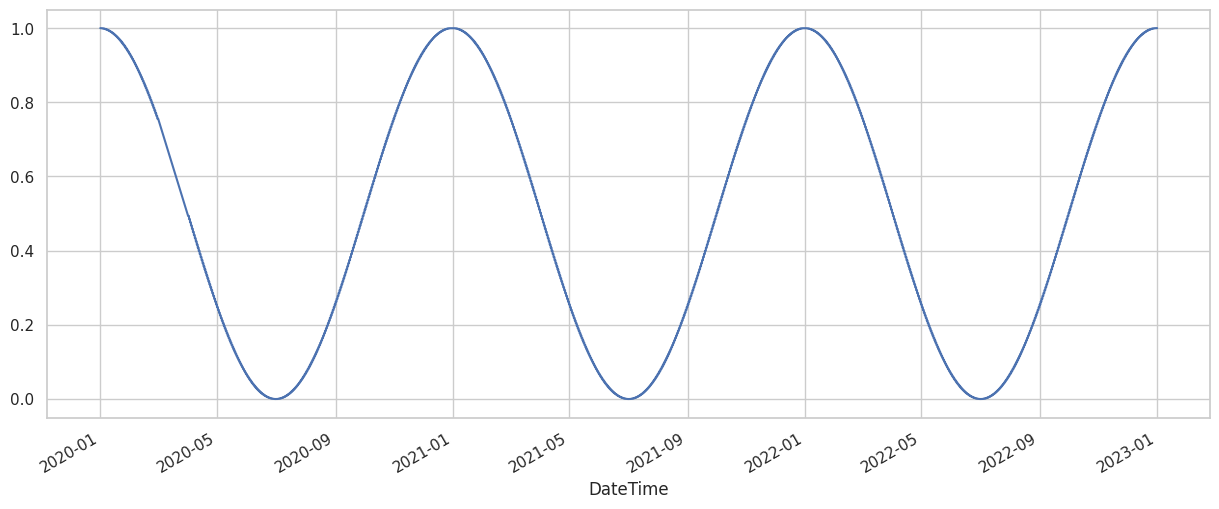

In [80]:
solar_train_scaled[2].plot();

Создаем новый Dataset и Dataloader

In [81]:
class SolarDatasetWithSin(Dataset):
    def __init__(self, data, n_lags, horizon):
        self.n_lags = n_lags
        self.horizon = horizon
        data = data
        self.x = torch.tensor(data[:-self.horizon], dtype=torch.float32)
        self.y = torch.tensor(data[self.n_lags:],dtype=torch.float32)

    def __getitem__(self, idx):
        return self.x[idx:idx+self.n_lags], self.y[idx:idx+self.horizon]

    def __len__(self):
        return self.y.shape[0]-self.horizon+1

In [83]:
N_LAGS = 20
HORIZON = 20

solar_dataset = SolarDatasetWithSin(solar_train_scaled.values, N_LAGS, HORIZON)

solar_train_size = int(0.8 * len(solar_dataset))
solar_valid_size = len(solar_dataset) - solar_train_size

solar_train_dataset = Subset(solar_dataset, range(solar_train_size))
solar_valid_dataset = Subset(
    solar_dataset, range(solar_train_size, solar_train_size + solar_valid_size))

batch_size = 1024

solar_train_loader = DataLoader(solar_train_dataset, batch_size=batch_size, shuffle=True)
solar_valid_loader = DataLoader(solar_valid_dataset, batch_size=batch_size, shuffle=True)

Определяем новую модель

In [84]:
class LSTMForecastAuto(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)

    def forward(self, input_seq, horizon):
        outputs = []

        # Прогоняем весь input_seq и получаем hidden state
        lstm_out, (hn, cn) = self.lstm(input_seq)

        # Берем последний выход и делаем первое предсказание
        pred = self.linear(lstm_out[:, -1, :])         # [batch, input_size]
        outputs.append(pred.unsqueeze(1))              # [batch, 1, input_size]
        input_step = pred.unsqueeze(1)                 # для следующего шага

        for _ in range(horizon - 1):
            out, (hn, cn) = self.lstm(input_step, (hn, cn))
            pred = self.linear(out[:, -1, :])          # [batch, input_size]
            outputs.append(pred.unsqueeze(1))          # [batch, 1, input_size]
            input_step = pred.unsqueeze(1)

        return torch.cat(outputs, dim=1)               # [batch, horizon, input_size]

Инициализируем и обучаем модель

In [92]:
HIDDEN_SIZE = 64
LSTM_LAYERS = 1

LSTM_model_2 = LSTMForecastAuto(input_size=3, hidden_size=HIDDEN_SIZE, num_layers=LSTM_LAYERS).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(LSTM_model_2.parameters(), lr=0.01)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3,
                                           patience=3, threshold=0.0001)

epochs = 100

In [93]:
LSTM_model_2, losses, lr = train_model(LSTM_model_2, loss_fn, optimizer, scheduler, num_epochs=epochs)

100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


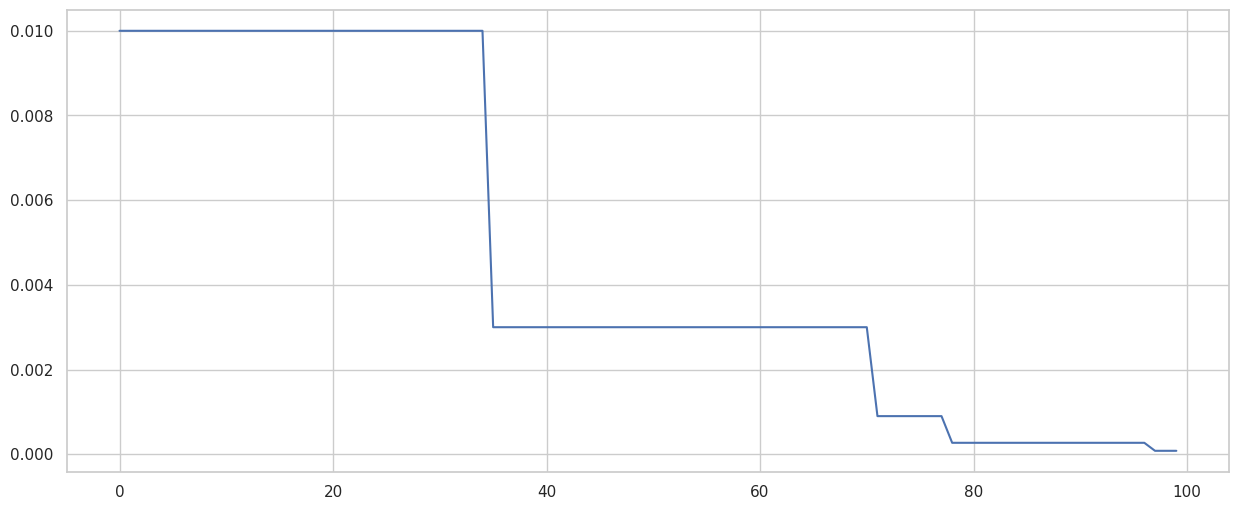

In [94]:
plt.plot(lr);

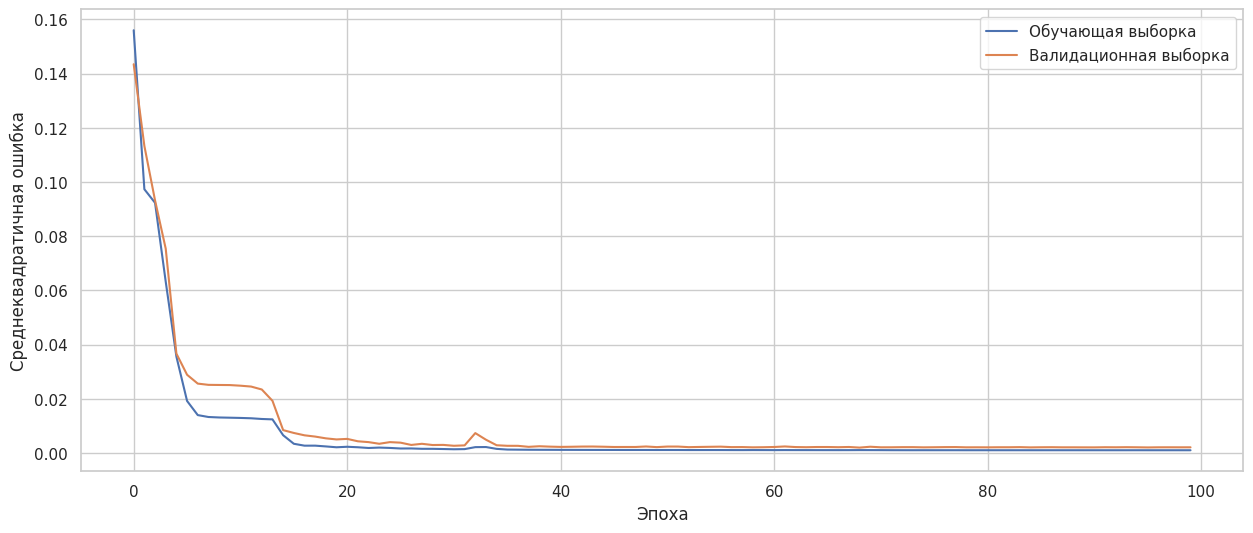

In [95]:
plt.plot(losses["train"], label="Обучающая выборка");
plt.plot(losses["valid"], label="Валидационная выборка");
plt.legend();
plt.xlabel("Эпоха");
plt.ylabel("Среднеквадратичная ошибка");

In [96]:
print(f"Минимальный loss на тренировочной выборке: {min(losses['train']):.4f}")
print(f"Минимальный loss на валидационной выборке: {min(losses['valid']):.4f}")

Минимальный loss на тренировочной выборке: 0.0011
Минимальный loss на валидационной выборке: 0.0021


#### Анализ качества модели

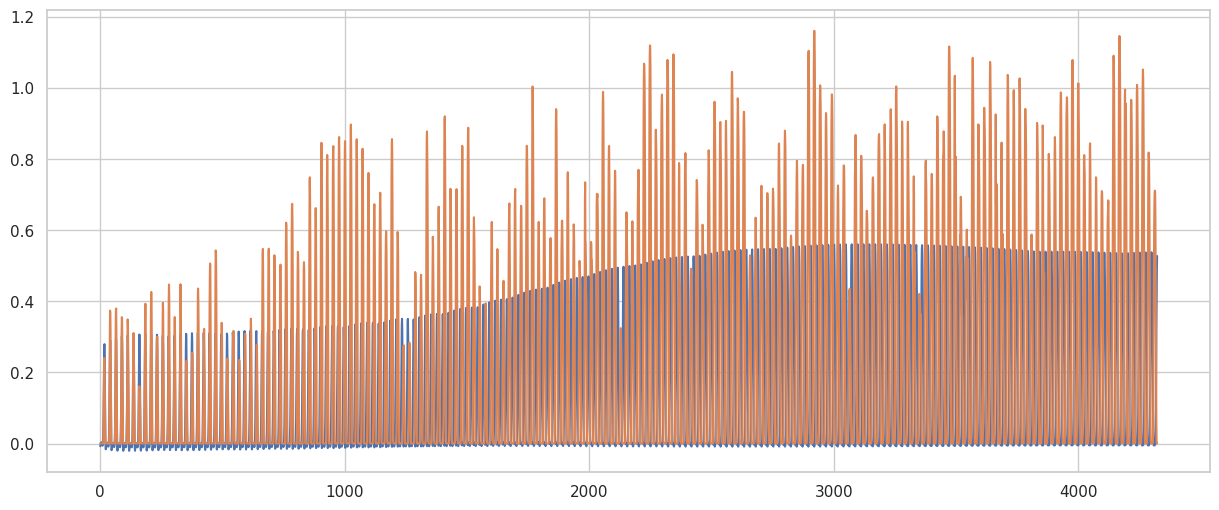

In [124]:
LSTM_model_2.to('cpu')

# horizon_for_test = 100
horizon_for_test = solar_test_scaled.shape[0] - N_LAGS

lstm2_pred = LSTM_model_2(
    torch.tensor(
        solar_test_scaled.values[:N_LAGS][None,:,:],
        dtype=torch.float32),
    horizon_for_test
    )[0]

plt.plot(lstm2_pred[:,0].detach().numpy());
plt.plot(solar_test_scaled.values[N_LAGS:N_LAGS+horizon_for_test][:,0]);

**MAE (Mean Absolute Error)**

Средняя абсолютная ошибка:

In [125]:
len_of_seq = np.min(
    [lstm2_pred.shape[0], solar_test_scaled.values[N_LAGS:,:].shape[0]])

lstm2_mae = mean_absolute_error(
    solar_test_scaled.values[N_LAGS:][:len_of_seq][:,0],
    lstm2_pred[:len_of_seq].detach().numpy()[:,0]
)

baseline_mae = mean_absolute_error(
    solar_test_scaled.values[N_LAGS:][:len_of_seq][:,0],
    solar_baseline_pred[N_LAGS:][:len_of_seq]
)

print(f"LSTM2 MAE: {lstm2_mae:.4f}")
print(f"Baseline MAE: {baseline_mae:.4f}")

MAE_prediction["LSTM2"] = lstm_mae

LSTM2 MAE: 0.3158
Baseline MAE: 0.2602


**RMSE (Root Mean Squared Error)**

Корень из средней квадратичной ошибки:

In [126]:
lstm2_rmse = mean_squared_error(
    solar_test_scaled.values[N_LAGS:][:len_of_seq][:,0],
    lstm2_pred[:len_of_seq].detach().numpy()[:,0]
)

baseline_rmse = mean_squared_error(
    solar_test_scaled.values[N_LAGS:][:len_of_seq][:,0],
    solar_baseline_pred[N_LAGS:][:len_of_seq]
)

print(f"LSTM2 RMSE: {lstm2_rmse:.4f}")
print(f"Baseline RMSE: {baseline_rmse:.4f}")

RMSE_prediction["LSTM2"] = lstm2_rmse

LSTM2 RMSE: 0.1799
Baseline RMSE: 0.0944


In [98]:
print(f"Число параметров FC модели: {sum(p.numel() for p in FC_model.parameters() if p.requires_grad)}")
print(f"Число параметров LSTM модели: {sum(p.numel() for p in LSTM_model.parameters() if p.requires_grad)}")
print(f"Число параметров LSTM модели с доп. признаками: {sum(p.numel() for p in LSTM_model_2.parameters() if p.requires_grad)}")

Число параметров FC модели: 1163364
Число параметров LSTM модели: 17217
Число параметров LSTM модели с доп. признаками: 17859
